# **Computer Vision - Assignment 3 - IMAGE REGISTRATION USING HOMOGRAPHIES**
#### Value: 10 (+4) points | Due date: December 22 23:59 | Submission site: https://pradogrado2223.ugr.es/

### Student's Full Name: <mark>Fernando Luque de la Torre</mark>


In this assignment you will learn:

a) How to detect relevant regions using the Harris's algorithm.

b) How to detect matches between images using SIFT descriptors.

c) How to compose a mosaic from a bunch of images. 

## Normas de entrega

Para este trabajo, al igual que para los demás, se deben presentar  las valoraciones y decisiones adoptadas en cada uno de los apartados. También deberá incluirse una valoración sobre la calidad de los resultados obtenidos. Se recuerda que código sin informe explicativo no puntúa.

Para poder evaluar el BONUS se debe obtener al menos el 70% de los puntos de la parte obligatoria

Normas de entrega (EL INCUMPLIMIENTO DE ESTAS NORMAS SIGNIFICA PÉRDIDA DIRECTA DE 1 PUNTO CADA VEZ QUE SE DETECTE UN INCUMPLIMIENTO):

1. El diseño de celdas del documento debe ser respetado.
2. Solo se entregará el código fuente (fichero .ipynb, y ficheros auxiliares externos: P0.py y P1.py) y no se enviarán las imágenes empleadas.
3. Los path que se usen en la lectura de imágenes o cualquier otro fichero de entrada debe ser siempre “/content/drive/My Drive/images/nombre_fichero”
4. El código deberá  presentarse junto con los resultados obtenidos en cada apartado y los  correspondientes comentarios, explicaciones y valoraciones.  Recuerde que la entrega de código sin informe explicativo o valoraciones no puntúa.

The next cell is intended to install an upgrade of the OpenCV package that includes the SIFT algorithm. After the installation, the  python-kernel (restart runtime) has to be restarted to import the new release.

In [1]:
import sys, cv2
(major, minor,_)=cv2.__version__.split(".")
if int(minor) < 5:
  if 'google.colab' in sys.modules:
    import subprocess
    subprocess.call("pip install -U opencv-python".split())

print(cv2.__version__)

4.6.0


This cell sets the environment and imports your packages

In [2]:
# Let's start importing all background modules
# We start by getting access to the drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import sys,os
# change directory
%cd '/content/drive/My Drive'
# Let's import the python module exercises.py  to have access to its functions and Classes
path_to_module='/content/drive/My Drive/CV/'
sys.path.append(os.path.abspath(path_to_module))
import P0,P1
get_image = lambda route: os.path.join('/content/drive/My Drive/images/', route)
import numpy as np
from matplotlib import pyplot as plt

Mounted at /content/drive
/content/drive/My Drive


# **Exercise 1:** Harris detector and non-maxima suppresion (3 points)

Write Python code to implement the detection of the strongest 100-150 Harris points in an image, and show your results using the function cv2.drawKeyPoints(). You can apply OpenCV's functions getDerivKernels() and sepFilter2D(). However, those who use their own code from P1 (for computing the derivatives) could have a bonus of +1 point. 

Hint (use different cells for the items):\
a) Fix the derivative and integration scales. Try first sigma values in the range 1-3.\
b) Compute the derivative images. \
c) Compute the three terms of the second moment matrix (SMM) at each pixel. To do it, apply the convolution with a Gaussian mask of size the integration area. \
d) Compute the Harris value at each pixel (discard the points close to the edges).\
e) Apply Non-Maxima Suppression by using the function corner_peaks() from the module skimage.features. The student must set the minimum distace between maxima. The output will be a list of (x,y) coordinates.  Extract the values in these coordinates and create a list of vectors (x,y,value).\
f) Compute the main orientation for each point. This is done by smoothing both derivative images with a sufficiently large sigma (sigma=3) and computing the orientation of the gradient at those points.\
d) Create a list of KeyPoints using the selected points. A KeyPoint is a vector including (x,y,scale,orientation).\
e) Draw the keypoints on the image using the function cv2.drawKeypoints().


En este primer ejercicio llevaremos a cabo la implementación del algoritmo de Harris.

Como sabemos, el algoritmo de Harris se basa en la utilización de las derivadas de primer orden (gradiente) para la detección de puntos Harris.

El proceso a seguir es el siguiente:
1. Cálculo de las derivadas de la imagen
2. Cálculo de la matriz H para toda la imagen
3. Cálculo del valor Harris en cada píxel de la imagen: $\large f_H = \frac{det(H)}{trace(H)}$
4. Con la función NonMaximaSuppression nos encargamos de eliminar los puntos que no son máximos por medio de una distancia mínima entre máximos y un threshold
5. Una vez filtrados los no máximos, calculamos la orientación de los puntos detectados: $\large θ=\frac{\arctan(\frac{smooth(dy)}{smooth(dx)}·180)}{π}$
6. Una vez obtenidos los puntos y las orientaciones, los añadimos a las imágenes con la función drawKeypoints.

In [3]:
# Compute image derivatives
def derivatives(im,sigmaD):
  return P1.gradientIM(im,sigmaD)

# Compute Harris-criterium Map
def HarrisMap(dx,dy,sigmaI):
  # Compute the three terms of the SMM at each pixel and he map values
  dxx = dx*dx
  dyy = dy*dy
  dxy = dx*dy

  H11 = P1.my2DConv(dxx,sigmaI,[0,0])
  H12 = P1.my2DConv(dxy,sigmaI,[0,0])
  H22 = P1.my2DConv(dyy,sigmaI,[0,0])

  HMap = (H11*H22 - H12*H12) / (H11+H22)

  return HMap

The following cell implements the Non-Maxima-Suppression stage. This function calls the corner_peaks() function from the skimage.feature package (see below). This function returns the local maxima sorted by value.

In [4]:
def NonMaximaSuppression(harrisMap, min_distance, threshold):
  points = corner_peaks(harrisMap, min_distance, threshold_abs=threshold)
  coord = points
  # Debemos recordar más tarde que coord yy harrisMap tienen coordenadas
  # fila/columna mientras que para dibujar debemos pasar a coordenadas
  # eje x / eje y (columna / fila)
  values = harrisMap[coord[:,0], coord[:,1]]

  return coord, values

Orientation is computed as the angle of the gradient after smoothing the derivative images with a Gaussian (with sigma=3).

A KeyPoint is an OpenCV's structure, associated to each detected region,  necessary to call OpenCV feature extraction algorithms. You have to create one KeyPoint structure per detected region with information about (location, scale,orientation). (See the OpenCV documentation for more information)

In [5]:
# compute the orientation map
def orientation(dx,dy):
  # Let's compute  orientation in degrees
  smoothdx = P1.my2DConv(dx, 3, [0,0])
  smoothdy = P1.my2DConv(dy, 3, [0,0])
  theta = np.arctan(smoothdy/smoothdx)*180.0/np.pi
  return theta

# Create the KeyPoint list from the information about locations, orientations and scale 
# keyPoint=KeyPoint(x_float, y_float, scale_float,orientation_float), in Harris scale=1
# 
def keyPoints(coord,theta,size):
  xs = np.array(coord[:,0])
  ys = np.array(coord[:,1])
  thetas = theta[xs,ys]
  keyPoints = [None]*xs.size
  for i in range(xs.size):
    # Hacemos el cambio de fila/columna a x/y
    keyPoints[i] = cv2.KeyPoint(float(ys[i]),float(xs[i]),size=size,angle=thetas[i])
  return(keyPoints)  

The following cell computes the Harris KeyPoints detection (calling to the previously implemented functions, like derivatives(), HarrisMap(), NonMaximaSuppression(), orientation() and keyPoints()), and displays them on the image. Use the function cv2.drawKeypoints() with flags, cv2.DRAW_MATCHES_FLAGS_DRAW_OVER_OUTIMG+cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS.

En cuanto a los parámetros, utilizaremos:
* sigmaD: Será el sigma con el que calcularemos las derivadas de la imagen. Utilizaremos un valor de 1.5
* sigmaI: El sigma para las convoluciones aplicadas a las derivadas para el cálculo de la matriz. Normalmente, se recomienda un valor tal que: sigmaI=1.5·sigmaD
* sizeIMask: El tamaño de la máscara que busca los puntos de Harris como tal, será el tamaño del área que refleje drawKeypoints y estará calculado a partir de sigmaI. Como se comentó en prácticas anteriores, un valor de $k=3σ$ es suficiente para cubrir casi la totalidad del área de la gaussiana, por lo que, si $sizeIMask=2k+1⇒sizeIMask=2·3σ+1$
* min_distance: La distancia mínima entre máximos
* Threshold_MINVALUE: El valor mínimo de respuesta que debe dar un punto para ser considerado como keypoint

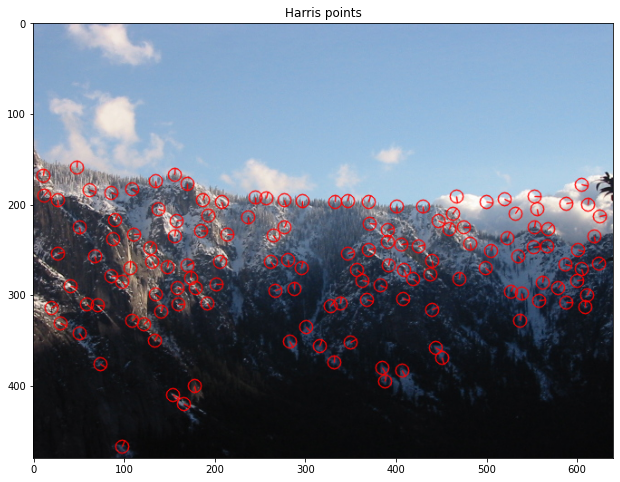

In [6]:
# Let's compute the KeyPoints-Harris and display them
#
from skimage.feature import corner_peaks
img=P0.readIm(P0.get_image('yosemite7.jpg'),0)
img = img.astype(np.float64)

#
# parameters
sigmaD=1.5
sigmaI=1.5*sigmaD
sizeIMask=sigmaI*3*2+1
min_distance=9
Threshold_MINVALUE=200

dx, dy = derivatives(img, sigmaD)
HMap = HarrisMap(dx,dy,sigmaI)

coord, values = NonMaximaSuppression(HMap, min_distance, Threshold_MINVALUE)

orientations = orientation(dx,dy)

keypoints=keyPoints(coord, orientations, sizeIMask)

img = P0.readIm(P0.get_image('yosemite7.jpg'),1)
img = cv2.drawKeypoints(img,keypoints,None,(255,0,0),flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.imshow(img)
plt.title("Harris points")
plt.gcf().set_size_inches(2*plt.gcf().get_size_inches())

Como vemos, los puntos devueltos por este algoritmo nos identifican puntos de interés dentro de la imagen, que pueden ser utilizados para caracterizar la misma.

El problema viene porque este algoritmo es monoescala, es decir, los puntos de interés que encontremos pertenecerán únicamente a una escala concreta, que definimos con los valores de $σ$ establecidos. El algoritmo de SIFT se centra en solucionar ese problema, y lo vamos a tratar en el siguiente ejercicio.

# **Exercise 2:** Matching keypoints between images using SIFT descriptors (2 points)

Write Python code to compute the matching between points from two images. To do so apply the SIFT algorithm to extract points and descriptors in both images.  Use the Force-Brute cross-check criteria and the KNN one to compute matches, and draw the matches between images using the function cv2.drawMatches(). 

El algoritmo de SIFT, a diferencia del detector Harris, realiza una búsqueda de blobs en todo el espacio de escalas. Para ello, utiliza la Laplaciana de la Gaussiana sobre una pirámide de diferentes octavas. Una vez detectados los puntos de interés, se calculan sus descriptores con el objetivo de caracterizarlos. Ya por último, se realizaría el proceso de matching, que se encargaría de relacionar los puntos SIFT de dos imágenes por medio de la similitud de sus descriptores

Por tanto, el primer paso sería la búsqueda de estos puntos, a los que a partir de ahora denominaremos keypoints.

Además de la búsqueda de keypoints, el método detectAndCompute de la clase SIFT permite calcular los descriptores asociados a dichos puntos a la vez que los buscamos.

In [7]:
# this function computes KeyPoints and descriptors in an image using SIFT
def siftPoints(img,nfeatures=5000):
  sift=cv2.xfeatures2d.SIFT_create(nfeatures=nfeatures)
  
  kp, ds = sift.detectAndCompute(img,None)

  return kp,ds

In OpenCV the output of a matching process is a vector of matches. Each match provides information about the indexes of the matched KeyPoints and the distance between them.

Una vez encontremos los keypoints y los descriptores de cada imagen, el siguiente paso será relacionarlos (matching). Para ello, podemos utilizar dos estrategias diferentes:
* Brute Force: O matching de fuerza bruta, se encarga de emparejar cada punto de la primera imagen con cada punto de la segunda imagen y de escoger la pareja que minimice la distancia. Al utilizar en nuestro caso el objeto BFMatcher con el crossCheck a True, cada match será considerado como tal, únicamente si la relación es en dos direcciones, es decir, un punto de la primera escoge a uno de la segunda, y este de la segunda también escoge al de la primera.
* KNN: Cada punto de la primera imagen se empareja con las dos mejores opciones de la segunda y se escoge solo si la distancia del mejor emparejamiento es menor que 0.75 veces la distancia del segundo mejor. En este caso no aplicaremos crossCheck, es decir, basta con que un punto de la primera imagen se asocie con uno de la segunda y no viceversa.

In [15]:
# This function display the KeyPoints of an image
def showKP(img,kp,title='Keypoints'):
  imgWithKP = cv2.drawKeypoints(img, kp, 0,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
  P0.displayIm(imgWithKP, title=title,factor=2)

# This function display the matches between two images
def showMatches(img1,kp1,img2,kp2,matches, N, title='Matches'):
  imgWithMatches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:N],None,flags=cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)
  P0.displayIm(imgWithMatches,title=title, factor=2)

#This function compute matches between descriptors of two images
def matching(ds1,ds2,FlagMode='BF'):
  if FlagMode=='BF':
    bf=cv2.BFMatcher.create(normType=cv2.NORM_L1, crossCheck=True)
    # Match descriptors.
    matches = bf.match(ds1, ds2)
    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)
    return matches

  elif FlagMode=='KNN':
    bf = cv2.BFMatcher.create(normType=cv2.NORM_L1, crossCheck=False)
    matches = bf.knnMatch(ds1,ds2,k=2)
    matches = sorted(matches, key = lambda x:x[0].distance)

    # Apply ratio test
    good = []
    for m,n in matches:
      if m.distance < 0.75*n.distance:
        good.append(m)
    
    return good
  else:
    return print('Error in Matching mode')

Now check your functions about KeyPoints and matching. To do so, read two consecutive images, let say Yosemite1 and Yosemite2, and show and analyze the results obtained.

Una vez declaradas las funciones, leeremos las imágenes, encontramos sus SIFT Keypoints y los mostramos

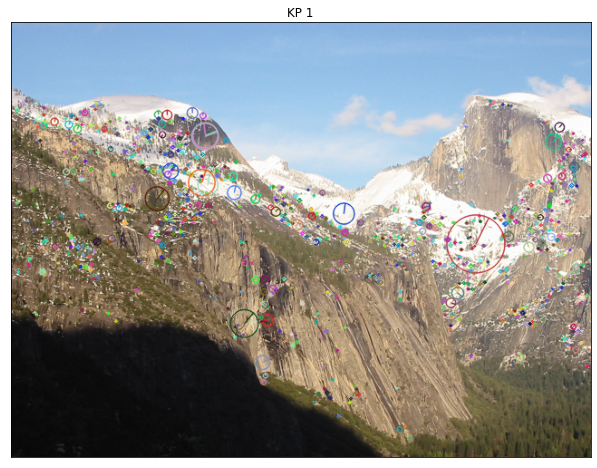

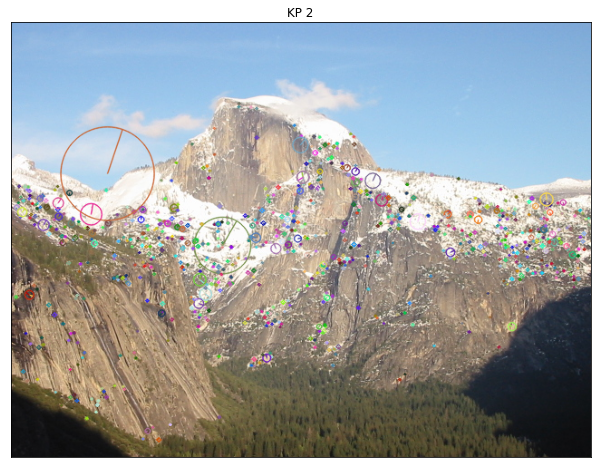

In [9]:
# Here we check our functions 
img1=P0.readIm('yosemite1.jpg',1)
img2=P0.readIm('yosemite2.jpg',1)
# let's compute points and descriptors
kp1, ds1 = siftPoints(img1,1000)
kp2, ds2 = siftPoints(img2,1000)

showKP(img1, kp1,"KP 1")
showKP(img2, kp2,"KP 2")

Una vez calculados los keypoints de cada una de las imágenes, vamos a llevar a cabo el matching de las dos formas que hemos analizado previamente.

En primer lugar, procederemos con el matching Bruteforce con crossCheck y mostramos los 100 mejores matches

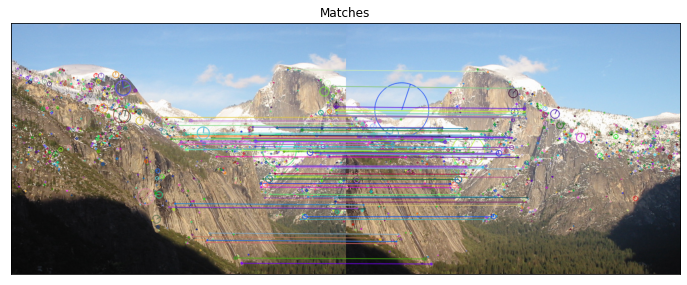

In [16]:
matches=matching(ds1, ds2, FlagMode='BF')
showMatches(img1, kp1, img2, kp2, matches, 100)

Procedemos ahora con el matching 2nn

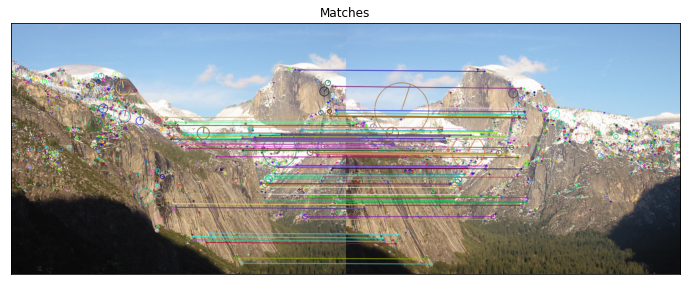

In [17]:
matches=matching(ds1, ds2, FlagMode='KNN')
showMatches(img1, kp1, img2, kp2, matches, 100)

Como vemos, ambas técnicas obtienen un buen matching y se consiguen gran cantidad de puntos relacionados de forma correcta.

Esto, nos supondrá un buen resultado en el siguiente ejercicio, en el que trataremos de construir un mosaico con diferentes imágenes de una misma escena.

# **Exercise 3.A:** Homographies calculation (1 point)

Now you are ready to calculate the homographies. To calculate the homography between two images call the function cv2.findHomography(), which takes as input the lists of located KeyPoints (in both images) and the matches found between them. Use RANSAC to perform a robust estimation.

Para la búsqueda de la homografía a partir de los matches entre dos imágenes, utilizaremos la función de OpenCV findHomography.

Esta función aceptará como parámetros los puntos de origen (los cuales podemos encontrar en el atributo queryIdx de cada uno de los objetos de matches) y los puntos de destino (en el atributo trainIdx), además del método utilizado para encontrar la homografía.

En nuestro caso, vamos a utilizar el método RANSAC que tal y como hemos visto en teoría, se utiliza para realizar un ajuste por mínimos cuadrados en el que se asume que hay outliers. El método RANSAC se encarga de encontrar el mayor grupo de puntos que estén de acuerdo con el modelo propuesto.

In [21]:
# this function computes a homography
def homography(kp1,kp2,matches, Ransac_Error,MIN_MATCH_COUNT=20):
  # the order is important
  if len(matches)>MIN_MATCH_COUNT:
    # Let's extract  two lists of points in correspondences from matches
    src_pts=np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
    dst_pts=np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)

    H, mask = cv2.findHomography(src_pts, dst_pts, Ransac_Error)
    print('Inliers:', sum(mask))
  else:
     print('Error - very few matches')
  return H

# **Exercise 3.B:** Building a mosaic (4 points)


To compose a mosaic we will need to set several pieces of information. \
a) The size of the canvas according to the number of images to be stitched and their dimensions.\
b) The central image that will give the axes to the mosaic.\
c) The order of each image with respect to the central one.\
d) The homography to copy the central image into the canvas.

Here is the guideline to compute a lineal Mosaic:\
a) Read the images in the order left-right of the camera.\
b) Set one central image as the reference to give axes to the canvas.\
c) Compute the homography between each two consecutive images in your list.\
d) Set the canvas and the reference homography.\
e) Compute the homography between each image and the canvas.\
f) Use  the function cv2.warpPerspective() to transport the images to the canvas using the computed homographies.\
g) Remove redundant black-pixels.



Una vez definida la función que nos da la homografía entre dos imágenes, podemos llevar a cabo el siguiente proceso para la composición del mosaico:
1. Calcular homografías por parejas en el orden en que las encontremos: la primera imagen con la segunda, la segunda con la tercera, etc. Esto es lo que se realiza en la función computeLocalHomographies

2. Una vez obtenidas dichas homografías, procedemos a combinarlas para convertirlas en homografías que nos lleven cada imagen al canvas. Es por eso que necesitaremos saber ya la imagen que va a ser central y la transformación de esta al canvas $H_0$:
  1. Las homografías desde idx a la derecha, es decir, aquellas que se aplicarán a las imágenes a la derecha de la central, deben ser invertidas, ya que queremos que las transformaciones nos lleven hacia la imagen central y no hacia la última
  2. Una vez invertidas las de la derecha, bastaría con componer todas las homografías, en un sentido para las imágenes de la izquierda y en el otro para las de la derecha, añadiendo a todas la transformación $H_0$ de traslación al canvas.

3. De esta forma, ya obtendríamos todas las homografías necesarias para construir nuestro mosaico.

In [24]:
# this function computes the homographies between each two consecutive images
def computeLocalHomographies(images):
  H=[]
  Ransac_Error=cv2.RANSAC
  for item in range(0,len(images)-1):
    kp1,ds1= siftPoints(images[item])
    kp2,ds2= siftPoints(images[item+1])
    matches=matching(ds1,ds2)
    Haux=homography(kp1,kp2,matches,MIN_MATCH_COUNT=20,Ransac_Error = Ransac_Error)
    H.append(Haux)
    # print(Haux)
  return H

import copy
# this function computes the homography from each image to the canvas
def mosaicHomographies(H,idx, H0):
  # idx is the index of the reference image
  # invert homographies
  # Haux[idx] = H0
  for item in range(idx,len(H)):
    H[item] = np.linalg.inv(H[item])
  if idx!=0:
    H[idx-1]=np.dot(H0, H[idx-1])
  # compute homographies by compositoon
  for item in range(idx-2,-1,-1):
    H[item] = np.dot(H[item+1],H[item])

  if idx!=len(H):
    H[idx] = np.dot(H0, H[idx])
    for item in range(idx+1,len(H),1):
      H[item] = np.dot(H[item-1],H[item])
  return H

# this function fixes the homography from the central image to the canvas
# others definitions are possible
def axesHomography(sizeim,sizecanvas):
  H=np.eye(3)
  H[0,2]=sizecanvas[1]//2-sizeim[1]//2
  H[1,2]=sizecanvas[0]//2-sizeim[0]//2
  return H

Con las homografías ya calculadas, la función composeMosaic se va a encargar de aplicarlas a las imágenes siguiendo un orden de los extremos hasta la imagen central, para que la imagen menos deformada sea la última que se transforme.

Para aplicar las homografías utilizaremos la función warpPerspective, la cual, además de las imágenes y la transformación a realizar, recibirá también un parámetro flags, en el que indicaremos qué tipo de interpolación utilizar para el blending, en nuestro caso, utilizaremos interpolación bilinear

In [56]:
# Auxiliary functions
# this function defines and return the canvas
def setCanvas(row,col,flagColor):
  if flagColor==3:
    return np.zeros((row,col,3))
  else:
    return np.zeros((row,col))

# This function removes the redundant black-pixels from the canvas
def blackOut(img):
  if len(img.shape)==3:
    im =cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    mask = np.array((im > 0), np.uint8) 
    x,y,w,h=cv2.boundingRect(mask)
    return img[y:y+h,x:x+w,:]
  else:
    mask = np.array((img > 0), np.uint8) 
    x,y,w,h=cv2.boundingRect(mask)
    return img[y:y+h,x:x+w]
  
# this function composes the mosaic from the extremes to the center
# transporting each image with its homography
def composeMosaic(images,canvas,H,idxc,H0,flagAffinity):
  w = canvas.shape[1]
  h = canvas.shape[0]
  for nim in range(0,idxc):
    canvas = cv2.warpPerspective(images[nim],H[nim], (w,h), None, borderMode=cv2.BORDER_TRANSPARENT, flags=cv2.INTER_LINEAR)
  for nim in range(len(images)-1,idxc,-1):
    canvas = cv2.warpPerspective(images[nim],H[nim-1], (w,h), None, borderMode=cv2.BORDER_TRANSPARENT, flags=cv2.INTER_LINEAR)
  canvas = cv2.warpPerspective(images[idxc] ,H0, (w,h) ,None , borderMode=cv2.BORDER_TRANSPARENT, flags=cv2.INTER_LINEAR)
  return canvas


The next cell contains the mosaic catalog with 5 possible scenarios: 

- EXAMPLE 1 (rectangular projection with 4 Yosemite images) (2 points)

- EXAMPLE 2 (rectangular projection with 8 corridor images) (3 points)

- EXAMPLE 3 (rectangular projection with 10 office images) (4 points)

- EXAMPLE 4 (14 images of Granada/Alhambra, mainly for spherical projection; see Bonus)

- EXAMPLE 5 (14 images of Sierra Nevada, mainly for spherical projection; see Bonus)

In [57]:
# CATALOG OF MOSAIC

# Mosaic construction: All of them are Left-Right camera motion

mosaicIndex=3
images = []
#EXAMPLE:1 (easy, for rectangular projection) (2 points)
if mosaicIndex==1: 
  nameImages=['yosemite1.jpg','yosemite2.jpg','yosemite3.jpg','yosemite4.jpg']
  for item in nameImages:
    images.append(P0.readIm(item,flagColor=1))
  
# EXAMPLE-2 (rectangular projection, tricky in a couple of homographies) (3 points)
elif mosaicIndex==2:
  nameImages=['Picture1.jpg','Picture2.jpg','Picture3.jpg','Picture4.jpg','Picture5.jpg','Picture6.jpg','Picture7.jpg','Picture8.jpg']
  for item in nameImages:
    images.append(P0.readIm(item,flagColor=1))

# EXAMPLE-3 (rectangular projection) (4 points)
elif mosaicIndex==3:
  nameImages=['mosaico002.jpg','mosaico003.jpg','mosaico004.jpg','mosaico005.jpg','mosaico006.jpg',
          'mosaico007.jpg','mosaico008.jpg','mosaico009.jpg','mosaico010.jpg','mosaico011.jpg']
  for item in nameImages:
    images.append(P0.readIm(item,flagColor=1))

# EXAMPLE-4 (mainly for spherical projection)
elif mosaicIndex==4:
  PREFIX='IMG_20211030_1104'
  nameImages=['10_S.jpg','13_S.jpg','15_S.jpg','17_S.jpg','18_S.jpg','20_S.jpg',
            '21_S.jpg', '25_S.jpg','26_S.jpg', '28_S.jpg','31_S.jpg','33_S.jpg',
            '34_S.jpg','36_S.jpg']
  for item in nameImages:
    images.append(P0.readIm(PREFIX+item,flagColor=1))


# EXAMPLE-5 (mainly for spherical projection)
elif mosaicIndex==5:
  PREFIX='IMG_20211030_1104'
  nameImages=['31_S.jpg','32_S.jpg','34_S.jpg','37_S.jpg','40_S.jpg','42_S.jpg',
          '44_S.jpg','46_S.jpg','48_S.jpg','50_S.jpg','51_S.jpg','54_S.jpg',
          '57_S.jpg','58_S.jpg'] 
  for item in nameImages:
    images.append(P0.readIm(PREFIX+item,flagColor=1))
else:
  print('Error - no such Mosaic')

Rectangular projection: The target is example-3. Example 1 and 2 are also possible but you get a lower mark (see the mosaic catalog). You must use all images.

Una vez cargadas las imágenes, procedemos a llevar a cabo el proceso descrito previamente llamando a las funciones que hemos declarado hasta ahora.

Como anotación previa, el tamaño del canvas me viene por la suma de las anchuras de todas las imágenes que componen el mosaico, y el alto tres veces la altura de la imagen más alta. El fondo sobrante se eliminará posteriormente con la función blackOut, por lo que nos conviene tener canvas de sobra

Read images:  10
idxc:  5
Inliers: [130]
Inliers: [124]
Inliers: [128]
Inliers: [162]
Inliers: [56]
Inliers: [84]
Inliers: [28]
Inliers: [116]
Inliers: [246]


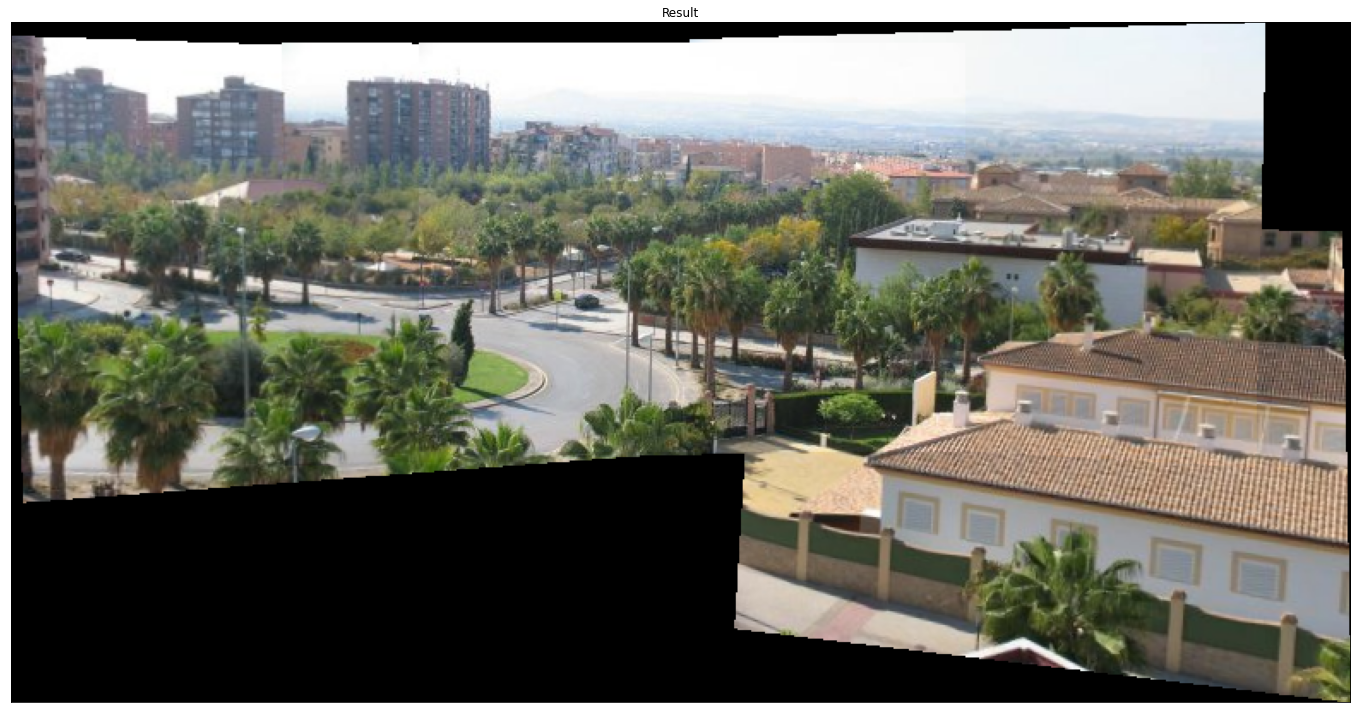

In [59]:
from numpy.linalg import inv
print('Read images: ',len(images))
# Set the central image 
idxc=len(images)//2
print('idxc: ',idxc)
# Compute local homographies beetwen images
H=computeLocalHomographies(images)

# Get the width and height of the canvas
width = 0
height = 0
for img in images:
  if img.shape[0]>height:
    height=img.shape[0]
  width = width+img.shape[1]
# Set the canvas
canvas=setCanvas(3*height, width,3).astype(np.uint8)

# Compute the homography given axis to the canvas
H0=axesHomography(images[idxc].shape, canvas.shape)

# Compute the homographies between images and the canvas
H=mosaicHomographies(H,idxc,H0)

# Compose the mosaic transporting the images into the canvas
mosaic= composeMosaic(images,canvas,H,idxc,H0,1).astype(np.uint8)
P0.displayIm(blackOut(mosaic),factor=4)

# **BONUS**: Spherical projection.  (3 points)
Use Examples 4 or 5's images and show the case f=500. You must use all images.

Procedemos ahora a realizar la proyección esférica.

El primer paso para ello sería transformar todas las imágenes a una proyección esférica:
1. Para esto, debemos elegir una distancia focal: $f$
2. A partir de esa distancia focal y de las dimensiones de la imagen, calculamos los valores de $θ$ y $ϕ$:

  theta = np.arctan2(widthIm,(2*f))

  phi = np.arctan2(heightIm,(2*f))

3. Creamos dos matrices del tamaño de la imagen:
  1. en la primera, los valores de cada fila variarán desde $-θ$ hasta $+θ$
  2. en la sgunda, los valores de cada columna variarán desde $-ϕ$ hasta $+ϕ$
4. De esta forma, cada posición de la imagen original se nos asocia con un valor de $θ$ y otro de $\phi$ concretos.
5. Ahora, mapearemos cada uno de las coordenadas de la imagen a coordenadas esféricas:

  $(\sinθ\cosϕ,\sin\phi,\cosθ\cos\phi)=(\hat x,\hat y,\hat z)$

6. Las coordenadas esféricas nos servirán para calcular las coordenadas de la imagen proyectada de la siguiente forma:

  $\Large x=f\frac{\hat x}{\hat z}+x_c$

  $\Large y=f\frac{\hat y}{\hat z}+y_c$

7. Por último, utilizamos la función remap para aplicar el mapping final

Una vez tenemos todas las imágenes con proyección esférica, podemos seguir el proceso del ejercicio anterior para construir el mosaico.

---
Como aclaración, la función sphericalTrim se encarga de "limpiar" los extremos de la imagen, es decir, recorta una cantidad de píxeles por cada uno de los lados para que el color negro no corte el mosaico



In [96]:
def spherical_lookupTable (f,imsize):
  # Here we compute the spherical coordinates where the image pixel project.
  # A sphere of radius r=f is fixed.
  # Begin by discretizing the azimuth and elevation ranges according to the image size and the focal length fixed. 
  # Then compute the coordinates on the sphere for each couple of angle-values ( azimuth and elevation)
  # return the computed coordinates
  # Slides and Szeliski's book equations will help
  # imsize (alto, ancho) porque usamos .shape
  width = imsize[1]
  height = imsize[0]
  theta = np.arctan2(width, 2*f)
  phi = np.arctan2(height, 2*f)

  x, y = np.meshgrid(np.linspace(-theta,theta,width), np.linspace(-phi,phi,height))

  return x.astype(np.float32),y.astype(np.float32)

def sphericalTrim(images,cutPix):
  # here we eliminate by left and right, above and below each image the number the
  # lines indicates in cutPix=[#row,#column]
  for idx,img in enumerate(images):
    images[idx] = img[cutPix[0]:img.shape[0]-cutPix[0],cutPix[1]:img.shape[1]-cutPix[1]]
    # img = img
  return images

def sphericalProjection(images,f,cutPix):
  # Here we interpolate a rectangular mesh of values from the  projection of the pixels.
  # images: set of images; f: focal length; cutpix: #row and #column to remove
  
  shpim = []
  for img in images:
    thetas, phis = spherical_lookupTable(f, img.shape)
    xc = img.shape[1]/2
    yc = img.shape[0]/2
    spherical_coords = np.array((
        np.sin(thetas)*np.cos(phis),
        np.sin(phis),
        np.cos(thetas)*np.cos(phis))
    )
    x_hat = spherical_coords[0,:,:]
    y_hat = spherical_coords[1,:,:]
    z_hat = spherical_coords[2,:,:]
    
    x = f*x_hat/z_hat+xc
    y = f*y_hat/z_hat+yc

    auxim = cv2.remap(img, x, y, interpolation=cv2.INTER_LINEAR)
    shpim.append(auxim)



  # after projection images must be trimmed
  shpim = sphericalTrim(shpim, cutPix)
  return shpim  # vector of projected images

In [109]:
# CATALOG OF MOSAIC

# Mosaic construction: All of them are Left-Right camera motion

mosaicIndex=4
images = []
#EXAMPLE:1 (easy, for rectangular projection) (2 points)
if mosaicIndex==1: 
  nameImages=['yosemite1.jpg','yosemite2.jpg','yosemite3.jpg','yosemite4.jpg']
  for item in nameImages:
    images.append(P0.readIm(item,flagColor=1))
  
# EXAMPLE-2 (rectangular projection, tricky in a couple of homographies) (3 points)
elif mosaicIndex==2:
  nameImages=['Picture1.jpg','Picture2.jpg','Picture3.jpg','Picture4.jpg','Picture5.jpg','Picture6.jpg','Picture7.jpg','Picture8.jpg']
  for item in nameImages:
    images.append(P0.readIm(item,flagColor=1))

# EXAMPLE-3 (rectangular projection) (4 points)
elif mosaicIndex==3:
  nameImages=['mosaico002.jpg','mosaico003.jpg','mosaico004.jpg','mosaico005.jpg','mosaico006.jpg',
          'mosaico007.jpg','mosaico008.jpg','mosaico009.jpg','mosaico010.jpg','mosaico011.jpg']
  for item in nameImages:
    images.append(P0.readIm(item,flagColor=1))

# EXAMPLE-4 (mainly for spherical projection)
elif mosaicIndex==4:
  PREFIX='IMG_20211030_1104'
  nameImages=['10_S.jpg','13_S.jpg','15_S.jpg','17_S.jpg','18_S.jpg','20_S.jpg',
            '21_S.jpg', '25_S.jpg','26_S.jpg', '28_S.jpg','31_S.jpg','33_S.jpg',
            '34_S.jpg','36_S.jpg']
  for item in nameImages:
    images.append(P0.readIm(PREFIX+item,flagColor=1))


# EXAMPLE-5 (mainly for spherical projection)
elif mosaicIndex==5:
  PREFIX='IMG_20211030_1104'
  nameImages=['31_S.jpg','32_S.jpg','34_S.jpg','37_S.jpg','40_S.jpg','42_S.jpg',
          '44_S.jpg','46_S.jpg','48_S.jpg','50_S.jpg','51_S.jpg','54_S.jpg',
          '57_S.jpg','58_S.jpg'] 
  for item in nameImages:
    images.append(P0.readIm(PREFIX+item,flagColor=1))
else:
  print('Error - no such Mosaic')

Una vez cargadas las imágenes y definidas las funciones que las transforman a proyección esférica, construimos el mosaico: con una distancia focal de 500 y recortando 15 píxeles por cada lado por cada imagen para quitar los bordes negros (tras realizar varias pruebas me ha dado un buen resultado)

Read images:  14
idxc:  7
Inliers: [181]
Inliers: [248]
Inliers: [0]
Inliers: [221]
Inliers: [23]
Inliers: [74]
Inliers: [243]
Inliers: [243]
Inliers: [13]
Inliers: [22]
Inliers: [56]
Inliers: [132]
Inliers: [110]


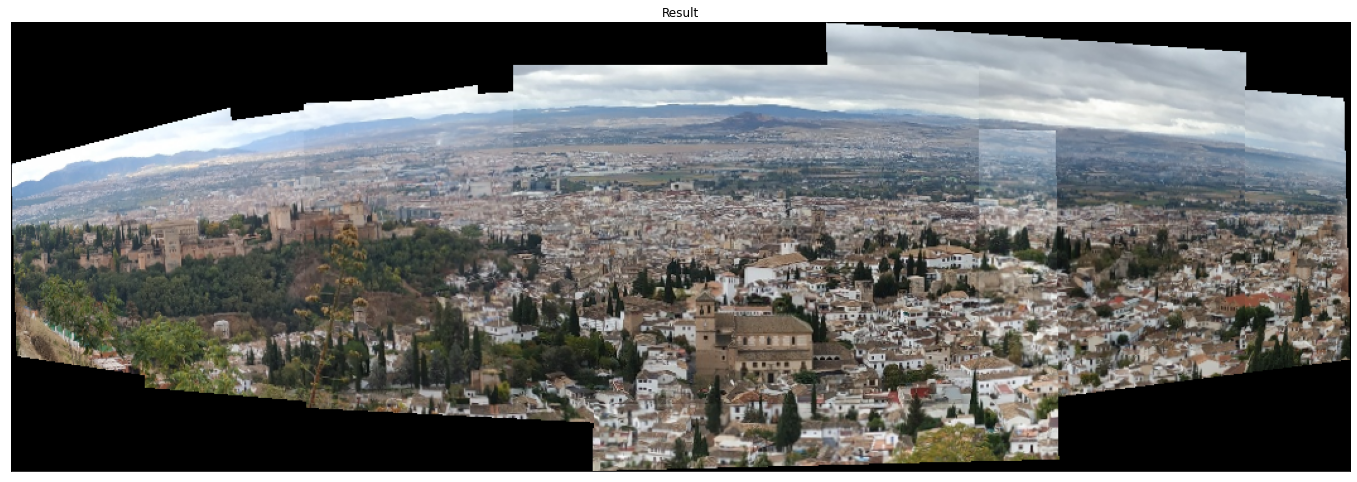

In [110]:
from numpy.linalg import inv

flagSpherical=True
if flagSpherical:
  images=sphericalProjection(images,500,[15,15])

print('Read images: ',len(images))
# Set the central image 
idxc=len(images)//2
print('idxc: ',idxc)
# Compute local homographies beetwen images
H=computeLocalHomographies(images)

# Get the width and height of the canvas
width = 0
height = 0
for img in images:
  if img.shape[0]>height:
    height=img.shape[0]
  width = width+img.shape[1]
# Set the canvas
canvas=setCanvas(3*height, width,3).astype(np.uint8)

# Compute the homography given axis to the canvas
H0=axesHomography(images[idxc].shape, canvas.shape)

# Compute the homographies between images and the canvas
H=mosaicHomographies(H,idxc,H0)

# Compose the mosaic transporting the images into the canvas
mosaic= composeMosaic(images,canvas,H,idxc,H0,1).astype(np.uint8)
P0.displayIm(blackOut(mosaic),factor=4)